In [1]:
#velocity reconstruction: for single smoothing scale, vlin_interp removed from data channel, separated baseline for linear theory comparison
#cnn input: position

import os, time, random
import numpy as np, h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import RegularGridInterpolator
from numpy.fft import fftn, ifftn, fftfreq

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

In [2]:
GRID_FILE = "Grids_Mcdm_IllustrisTNG_1P_128_z=0.0.npy"
TRAIN_HALO_FILE = "groups_090_1P_0.hdf5"
TEST_HALO_FILE  = "groups_090_1P_p2_n1.hdf5"   
TRAIN_REAL_IDX = 0
TEST_REAL_IDX = 14

PATCH = 32
BATCH = 16           
EPOCHS = 60
LR = 1e-4
WEIGHT_DECAY = 1e-5
MASS_CUT = 1e11
BOXSIZE = 25.0
MAX_HALOS = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AUGMENT = True
PATIENCE = 14
SMOOTH_SCALE = 2.0
CHECKPOINT_DIR = "checkpoints_no_vlin_improved_v2"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
SEED = 42
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# pearson penalty weight (try 0.01 - 0.2)
PEARSON_WEIGHT = 0.08

# test-time augmentation toggle (flip x/y)
TTA = True

print("Device:", DEVICE)


Device: cuda


In [3]:
def memmap_grid_slices(grid_file, idxs):
    if isinstance(idxs, int): idxs = [idxs]
    arr = np.load(grid_file, allow_pickle=False, mmap_mode='r')
    return [np.asarray(arr[i], dtype=np.float32) for i in idxs]

In [4]:
def load_halos(hfile):
    with h5py.File(hfile, "r") as f:
        pos = np.array(f["Group/GroupPos"]) / 1000.0  # ckpc/h -> Mpc/h
        vel = np.array(f["Group/GroupVel"])
        mass = np.array(f["Group/Group_M_Mean200"]) * 1e10
    return pos, vel, mass


In [5]:
def smooth_density_kspace(rho_cdm, R_smooth, boxsize=BOXSIZE):
    rho = np.asarray(rho_cdm, dtype=np.float32)
    delta = rho / rho.mean() - 1.0
    if R_smooth == 0.0:
        return delta.astype(np.float32)
    N = rho.shape[0]
    dk = fftn(delta)
    kfreq = fftfreq(N, d=boxsize/N)
    kx, ky, kz = np.meshgrid(2*np.pi*kfreq, 2*np.pi*kfreq, 2*np.pi*kfreq, indexing='ij')
    k2 = kx**2 + ky**2 + kz**2
    W = np.exp(-0.5 * k2 * (R_smooth**2))
    return ifftn(dk * W).real.astype(np.float32)

In [6]:
def compute_vlin_from_density(rho_cdm, z_snap=0.0, boxsize=BOXSIZE,
                              H0=67.66, Omega_m0=0.3, R_smooth=2.0):
    N = rho_cdm.shape[0]
    a = 1.0 / (1.0 + z_snap)
    Hz = H0 * np.sqrt(Omega_m0 * (1+z_snap)**3 + 1.0 - Omega_m0)
    f = (Omega_m0*(1+z_snap)**3 / (Omega_m0*(1+z_snap)**3 + 1.0 - Omega_m0))**0.55
    delta_x = rho_cdm / np.mean(rho_cdm) - 1.0
    dk = fftn(delta_x)
    kfreq = fftfreq(N, d=boxsize/N)
    kx, ky, kz = np.meshgrid(2*np.pi*kfreq, 2*np.pi*kfreq, 2*np.pi*kfreq, indexing='ij')
    k2 = kx**2 + ky**2 + kz**2
    k2_nozero = np.where(k2 == 0, 1.0, k2)
    pref = 1j * a * Hz * f
    vz_k = pref * (kz / k2_nozero) * dk
    vz_k[k2 == 0] = 0.0
    if R_smooth is not None and R_smooth > 0.0:
        W = np.exp(-0.5 * k2 * (R_smooth**2))
        vz_k *= W
    vz_x = ifftn(vz_k).real
    return vz_x.astype(np.float32)

In [7]:
def build_vlin_interpolator(vlin_grid):
    N = vlin_grid.shape[0]
    cell = BOXSIZE / N
    coords = (np.arange(N) + 0.5) * cell
    return RegularGridInterpolator((coords, coords, coords), vlin_grid,
                                   bounds_error=False, fill_value=0.0)


In [8]:
# ---------------- Dataset ----------------
class PositionOnlyHaloDataset(Dataset):
    def __init__(self, pos, vel, mass,
                 pos_mean=None, pos_std=None,
                 mass_cut=MASS_CUT, max_n=MAX_HALOS, rng=None):

        if rng is None:
            rng = np.random.RandomState(SEED)

        # --- Mass cut (KEEP) ---
        mask = mass > mass_cut
        pos_sel, vel_sel = pos[mask], vel[mask]

        # --- Downsample (KEEP) ---
        if max_n is not None and len(pos_sel) > max_n:
            sel = rng.choice(len(pos_sel), max_n, replace=False)
            pos_sel, vel_sel = pos_sel[sel], vel_sel[sel]

        # --- Store halo data ---
        self.pos = pos_sel.astype(np.float32)          # (N, 3)
        self.vz  = vel_sel[:, 2].astype(np.float32)    # (N,)

        # --- Position normalization (TRAIN-BASED) ---
        self.pos_mean = pos_mean if pos_mean is not None else self.pos.mean(axis=0)
        self.pos_std  = pos_std  if pos_std  is not None else self.pos.std(axis=0) + 1e-12

        print(f"Selected {len(self.pos)} halos (mass_cut={mass_cut}, cap={max_n}).")

    def __len__(self):
        return len(self.pos)

    def __getitem__(self, idx):
        # --- INPUT: halo position only ---
        p = self.pos[idx]                       # (3,)
        p_norm = (p - self.pos_mean) / self.pos_std

        # --- TARGET ---
        y = self.vz[idx]

        return p_norm.astype(np.float32), np.float32(y)


In [9]:
class PosMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [10]:

def pearson_corr_torch(x, y, eps=1e-6):
    # x, y: tensors (batch,)
    xm = torch.mean(x)
    ym = torch.mean(y)
    xm0 = x - xm
    ym0 = y - ym
    cov = torch.mean(xm0 * ym0)
    sx = torch.sqrt(torch.mean(xm0 * xm0) + eps)
    sy = torch.sqrt(torch.mean(ym0 * ym0) + eps)
    corr = cov / (sx * sy + eps)
    return corr

In [11]:
def _compute_stats(true, pred):
    mask = np.isfinite(true) & np.isfinite(pred)
    n = int(mask.sum())
    if n == 0:
        return mask, np.nan, np.nan, np.nan, np.nan, np.nan, n
    t = true[mask]; p = pred[mask]
    try:
        corr = float(pearsonr(t, p)[0])
    except Exception:
        corr = np.nan
    bias = float(np.mean(p - t))
    rmse = float(np.sqrt(np.mean((p - t) ** 2)))
    rms_true = float(np.std(t))
    rms_pred = float(np.std(p))
    return mask, corr, bias, rmse, rms_true, rms_pred, n

In [12]:
def hexbin_panel(ax, true, pred, title, cmap="viridis"):
    mask, corr, bias, rmse, rms_true, rms_pred, n = _compute_stats(true, pred)
    vmax = max(np.max(np.abs(true[mask])), np.max(np.abs(pred[mask]))) if n > 0 else 1.0
    lims = [-vmax, vmax]

    hb = ax.hexbin(
        true[mask], pred[mask],
        gridsize=150,
        cmap=cmap,
        bins='log',
        mincnt=1,
        extent=(lims[0], lims[1], lims[0], lims[1])
    )

    ax.plot(lims, lims, 'r--', lw=1.2, label="1:1")
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("True LOS velocity (km/s)")
    ax.set_ylabel("Predicted LOS velocity (km/s)")
    ax.set_title(f"{title}\nρ = {corr:.3f}")

    stats_text = (
        f"N = {n}\n"
        f"ρ = {corr:.3f}\n"
        f"Bias = {bias:.2f}\n"
        f"RMSE = {rmse:.2f}\n"
        f"RMS(true) = {rms_true:.2f}\n"
        f"RMS(pred) = {rms_pred:.2f}"
    )

    ax.text(
        0.02, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=9,
        va='top',
        bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.85)
    )
    return hb

In [13]:
def vlin_at_halos(vlin_grid, halo_pos):
    """Interpolate linear-theory vz field at halo positions."""
    interp = build_vlin_interpolator(vlin_grid)
    pos_wrapped = (halo_pos % BOXSIZE)
    vals = [np.asarray(interp(tuple(p))).item() for p in pos_wrapped]
    return np.array(vals, dtype=np.float32)

In [22]:
def train_and_eval():
    """
    Train the CNN on one simulation realization and evaluate on another.

    CNN view of the problem:
      • Input x (xb): (x, y, z) coordinates
                       
     
      • Output: v_z (line-of-sight velocity) for each halo
                       shape ~ [batch]
    """
    grid_test = memmap_grid_slices(GRID_FILE, [TEST_REAL_IDX])
    grid_test = grid_test[0]
    # ---------- 3. Halos ----------
    pos_tr, vel_tr, mass_tr = load_halos(TRAIN_HALO_FILE)
    pos_te, vel_te, mass_te = load_halos(TEST_HALO_FILE)

    print("Loaded halos (train, test):", len(pos_tr), len(pos_te))

    # ---------- 5. Datasets ----------
    rng = np.random.RandomState(SEED)

    train_ds_full = PositionOnlyHaloDataset(
    pos_tr, vel_tr, mass_tr,
    mass_cut=MASS_CUT, max_n=MAX_HALOS, rng=rng
    )

    test_ds = PositionOnlyHaloDataset(
    pos_te, vel_te, mass_te,
    mass_cut=MASS_CUT, max_n=MAX_HALOS, rng=rng
    )


     #----------v_lin baseline------------ 
    print("Computing v_lin baseline (on CNN test halos)...")
    vlin_test = compute_vlin_from_density(grid_test, R_smooth=2.0)
    vlin_baseline = vlin_at_halos(vlin_test, test_ds.pos)   # uses mass-cut sample
    v_true_test   = test_ds.vz                              # same sample

    try:
        rho_vlin = pearsonr(v_true_test, vlin_baseline)[0]
    except Exception:
        rho_vlin = np.nan
    print(f"ρ (v_lin baseline, mass-cut halos) = {rho_vlin:.4f}")

    # ---------- 6. Train / validation split ----------
    idxs = np.arange(len(train_ds_full))
    tr_idx, val_idx = train_test_split(idxs, test_size=0.2, random_state=SEED)

    y_list = [train_ds_full[i][1] for i in tr_idx]  # v_z for training halos
    y_arr  = np.array(y_list, dtype=np.float32)
    y_mean = float(y_arr.mean())
    y_std  = float(y_arr.std() + 1e-12)
    print("Train v_z mean/std:", y_mean, y_std)

    tr_ds = Subset(train_ds_full, tr_idx)
    val_ds = Subset(train_ds_full, val_idx)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH, shuffle=True,  num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=0)
    te_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0)

    # ---------- 7. CNN model: inputs & output summary ----------
    print(
    "\nPosition-only model setup:"
    "\n  • Input: halo position (x, y, z)"
    "\n  • Output: line-of-sight velocity v_z\n"
    )

    model = PosMLP().to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=6, min_lr=1e-6
    )
    loss_fn = nn.SmoothL1Loss()

    best_val   = np.inf
    best_epoch = -1
    no_improve = 0
    best_ckpt_fixed = os.path.join(CHECKPOINT_DIR, "cnn_best.pth")

    # ---------- 8. Training loop ----------
    first_batch_shown = False  # for a one-time shape print

    for epoch in range(EPOCHS):
        t0 = time.time()
        model.train()

        train_losses = []
        train_preds  = []
        train_trues  = []

        for xb, y in tr_loader:
            xb = xb.to(DEVICE)     # (B, 3)
            y  = y.to(DEVICE)
            if y.dim() == 2 and y.size(1) == 1:
                y = y.view(-1)

            y_n = (y - y_mean) / y_std
            pred_n = model(xb)

            base_loss = loss_fn(pred_n, y_n)

            # Pearson penalty on *denormalized* v_z (matches our final metric)
            pred_den  = pred_n * y_std + y_mean
            true_den  = y
            p         = pearson_corr_torch(pred_den, true_den)
            pearson_loss = 1.0 - p          # push ρ → 1
            loss         = base_loss + PEARSON_WEIGHT * pearson_loss

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

            train_losses.append(loss.item() * xb.size(0))
            train_preds.append(pred_den.detach().cpu().numpy().reshape(-1))
            train_trues.append(y.cpu().numpy().reshape(-1))

        train_loss = np.sum(train_losses) / len(tr_ds) if len(tr_ds) > 0 else np.nan
        train_preds = np.concatenate(train_preds) if train_preds else np.array([])
        train_trues = np.concatenate(train_trues) if train_trues else np.array([])

        try:
            train_rho = pearsonr(train_trues, train_preds)[0]
        except Exception:
            train_rho = np.nan

        # ---------- 9. Validation ----------
        model.eval()
        val_losses = []
        val_preds  = []
        val_trues  = []

        with torch.no_grad():
            for xb, y in val_loader:
                xb = xb.to(DEVICE)     # (B, 3)
                y  = y.to(DEVICE)

                if y.dim() == 2 and y.size(1) == 1:
                    y = y.view(-1)

                pred_n   = model(xb)
                pred_den = pred_n * y_std + y_mean

                val_preds.append(pred_den.cpu().numpy().reshape(-1))
                val_trues.append(y.cpu().numpy().reshape(-1))

                # MSE in normalized space, aggregated by sample count
                val_losses.append(((pred_n - (y - y_mean) / y_std) ** 2).mean().item() * xb.size(0))

        val_preds = np.concatenate(val_preds) if val_preds else np.array([])
        val_trues = np.concatenate(val_trues) if val_trues else np.array([])
        val_loss  = np.sum(val_losses) / len(val_ds) if len(val_ds) > 0 else np.nan

        try:
            val_rho = pearsonr(val_trues, val_preds)[0]
        except Exception:
            val_rho = np.nan

        scheduler.step(val_loss)
        dt = time.time() - t0

        print(
            f"Epoch {epoch+1}/{EPOCHS}  "
            f"TrainLoss={train_loss:.3e}  ρ_train={train_rho:.3f}  |  "
            f"ValLoss={val_loss:.3e}  ρ_val={val_rho:.3f}  |  {dt:.1f}s"
        )

        # Early-stopping logic
        if np.isfinite(val_loss) and val_loss < best_val - 1e-9:
            best_val   = val_loss
            best_epoch = epoch + 1
            no_improve = 0

            ckpt_path = os.path.join(CHECKPOINT_DIR, f"cnn_best_epoch{best_epoch}.pth")
            payload = {
                "model_state_dict": model.state_dict(),
                "y_mean": y_mean,
                "y_std":  y_std,
            }
            torch.save(payload, ckpt_path)
            torch.save(payload, best_ckpt_fixed)
            print("Saved checkpoint:", ckpt_path)
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print("Early stopping (no val improvement).")
                break

    print("Training finished. Best epoch:", best_epoch, "best val loss:", best_val)

    # ---------- 10. Load best model & test evaluation ----------
    ckpt = torch.load(best_ckpt_fixed, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    y_mean = ckpt.get("y_mean", y_mean)
    y_std  = ckpt.get("y_std",  y_std)
    model.eval()

    # Test predictions 
    preds_acc = []
    trues_acc = []

    with torch.no_grad():
        for xb, y in te_loader:
            xb     = xb.to(DEVICE)
            y  = y.to(DEVICE)

            if y.dim() == 2 and y.size(1) == 1:
                y = y.view(-1)

            pred_n   = model(xb)
            pred_den = pred_n.cpu().numpy().reshape(-1) * y_std + y_mean

            preds_acc.append(pred_den)
            trues_acc.append(y.cpu().numpy().reshape(-1))

    preds = np.concatenate(preds_acc) if preds_acc else np.array([])
    trues = np.concatenate(trues_acc) if trues_acc else np.array([])

    v_true_full = test_ds.vz
    v_pred_raw  = preds[:len(v_true_full)]

    def safe_pearson(x, y):
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 3:
            return np.nan
        return pearsonr(x[mask], y[mask])[0]

    rho_raw  = safe_pearson(v_true_full, v_pred_raw)
    bias_raw = float(np.mean(v_pred_raw - v_true_full))
    rmse_raw = float(np.sqrt(np.mean((v_pred_raw - v_true_full) ** 2)))

    print("----- Test metrics (configured test set) -----")
    print(
        f"Raw CNN: N={len(v_true_full)}, "
        f"ρ={rho_raw:.4f}, bias={bias_raw:.3f}, rmse={rmse_raw:.3f}"
    )
    print(f"Baseline v_lin ρ (interpolated) = {rho_vlin:.4f}")

    # ---------- 11. Plots: CNN vs linear theory ----------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    hb1 = hexbin_panel(
        axes[0],
        v_true_full,
        vlin_baseline,
        title="Linear Theory (v_lin)"
    )

    hb2 = hexbin_panel(
        axes[1],
        v_true_full,
        v_pred_raw,
        title="CNN (raw)"
    )

    cb_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(hb1, cax=cb_ax, label="log(count)")

    plt.suptitle(
        f"Velocity Reconstruction Comparison\n"
        f"Train Realization {TRAIN_REAL_IDX} → Test {TEST_REAL_IDX}",
        fontsize=16
    )

    out_compare = os.path.join(CHECKPOINT_DIR, "vlin_vs_cnn_comparison_raw.png")
    plt.savefig(out_compare, dpi=300, bbox_inches="tight")
    print("Saved:", out_compare)
    plt.show()

Loaded halos (train, test): 20817 21205
Selected 547 halos (mass_cut=100000000000.0, cap=5000).
Selected 569 halos (mass_cut=100000000000.0, cap=5000).
Computing v_lin baseline (on CNN test halos)...
ρ (v_lin baseline, mass-cut halos) = 0.8551
Train v_z mean/std: -1.0862698554992676 105.11466979980469

Position-only model setup:
  • Input: halo position (x, y, z)
  • Output: line-of-sight velocity v_z

Epoch 1/60  TrainLoss=4.460e-01  ρ_train=0.200  |  ValLoss=9.284e-01  ρ_val=0.222  |  0.1s
Saved checkpoint: checkpoints_no_vlin_improved_v2/cnn_best_epoch1.pth
Epoch 2/60  TrainLoss=4.069e-01  ρ_train=0.367  |  ValLoss=9.004e-01  ρ_val=0.285  |  0.1s
Saved checkpoint: checkpoints_no_vlin_improved_v2/cnn_best_epoch2.pth
Epoch 3/60  TrainLoss=3.921e-01  ρ_train=0.399  |  ValLoss=8.837e-01  ρ_val=0.309  |  0.1s
Saved checkpoint: checkpoints_no_vlin_improved_v2/cnn_best_epoch3.pth
Epoch 4/60  TrainLoss=3.796e-01  ρ_train=0.421  |  ValLoss=8.734e-01  ρ_val=0.322  |  0.1s
Saved checkpoint: ch

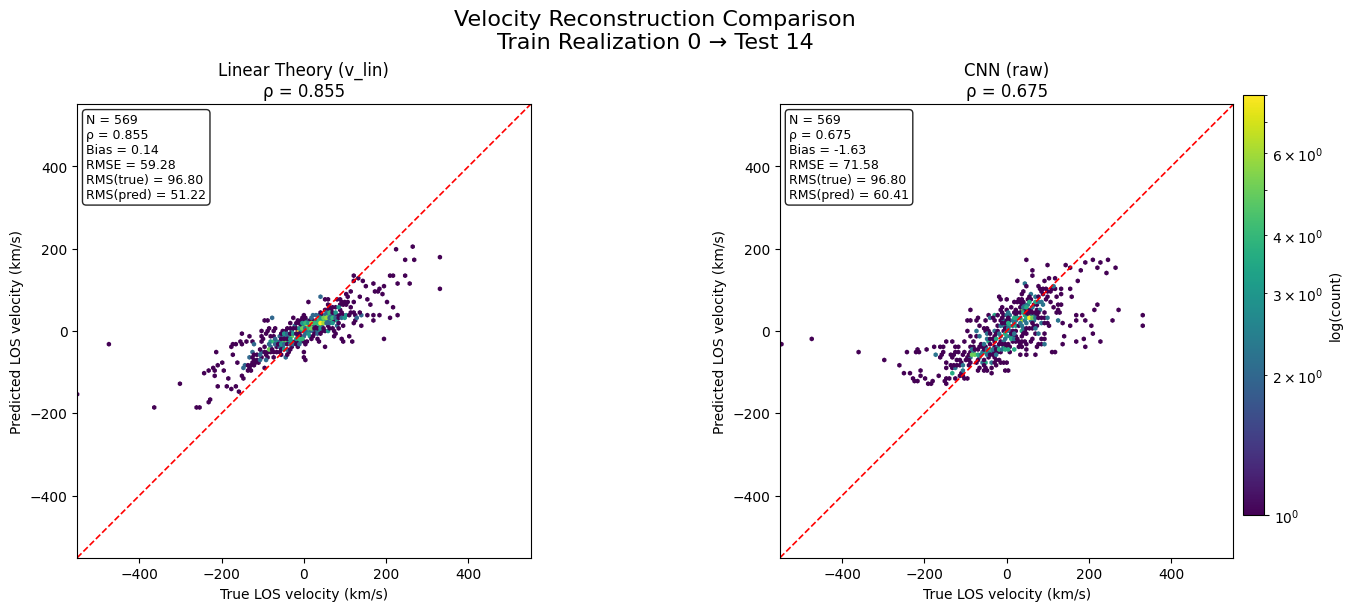

In [23]:
train_and_eval()